# CNN with non-softmax classification

## Backend and import

In [1]:

import os
import sys
import sklearn
import pip
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import deeplake
from time import time
from PIL import Image


from pathlib import Path
# set figure size
plt.rcParams['figure.figsize'] = [14, 14]
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Requirements taken from https://www.tensorflow.org/install/pip#linux
python_version = sys.version
pip_version = pip.__version__
nvidia_smi_version = os.popen('nvidia-smi --query-gpu=driver_version --format=csv,noheader').read().strip()
cuda_version = os.popen('nvcc --version').read().split('\n')[3].split(',')[1].strip()
tensorflow_version = tf.__version__
physical_devices = tf.config.list_physical_devices('GPU')
num_gpus = len(physical_devices)
gpu_model = os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read().strip()

req_xray_data = pd.DataFrame({
    'Package': ['Python', 'pip', 'nvidia-smi', 'cuda', 'tensorflow', 'GPUs'],
    'Required': ['3.7', '20.2', '450.51.06', '11.0', '2.3.0', '1'],
    'Installed': [python_version, pip_version, nvidia_smi_version, cuda_version, tensorflow_version, num_gpus]
})
               
print(f'All requiremetns met. Using TF with GPU: {gpu_model} ({num_gpus}x)')

pd.options.plotting.backend = "plotly"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

from keras.models import Model, Sequential
from keras.layers import Lambda, Input, GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import keras
from sklearn.metrics import classification_report, accuracy_score

import sys

sys.path.append('/home/kayaba_attribution/Documents/UoL/FINAL_PROJECT/Code/nih-chest')
sys.path.append(os.path.dirname(os.getcwd()))

from dataset import train_ds, val_ds, test_ds, y_test, y_val, ALL_LABELS, IMG_SIZE
from reportUtils import generate_report

MODEL_NAME = 'VGGSVM'

req_xray_data



2024-03-11 01:32:13.664115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 01:32:13.664147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 01:32:13.665266: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 01:32:13.671981: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 01:32:14.337388: W tensorflow/compiler/tf2

All requiremetns met. Using TF with GPU: NVIDIA GeForce GTX 1660 (1x)
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


2024-03-11 01:32:15.679008: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355



Train size: X: 61540, y: 61540 | Validation size: X: 15385, y: 15385 | Test size: X: 35195, y: 35195 | 
Total size: X: 112120


2024-03-11 01:32:15.995451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 01:32:15.995675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 01:32:15.995829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

,Package,Required,Installed
0,Python,3.7,"3.9.17 (main, Jul 5 2023, 20:41:20) \n[GCC 11..."
1,pip,20.2,23.2.1
2,nvidia-smi,450.51.06,535.54.03
3,cuda,11.0,release 12.2
4,tensorflow,2.3.0,2.15.0
5,GPUs,1,1


## Load Cifar10

## VGG-like CNN

In [5]:
featureLayer1=[Conv2D(64, (3, 3), padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)),
               Activation('relu'),
               Conv2D(64, (3, 3), padding='same'),
               Activation('relu'),
               MaxPooling2D(pool_size=(2, 2)),
               Dropout(0.25)]

featureLayer2=[Conv2D(128, (3, 3), padding='same'),
               Activation('relu'),
               Conv2D(128, (3, 3), padding='same'),
               Activation('relu'),
               MaxPooling2D(pool_size=(2, 2)),
               Dropout(0.25)]

featureLayer3=[Conv2D(256, (3, 3), padding='same'),
               Activation('relu'),
               Conv2D(256, (3, 3), padding='same'),
               Activation('relu'),
               Conv2D(256, (3, 3), padding='same'),
               Activation('relu'),
               MaxPooling2D(pool_size=(2, 2)),
               Dropout(0.25)]

fullConnLayer=[Flatten(),
               Dense(1024),
               Activation('relu'),
               Dropout(0.5),
               Dense(1024),
               Activation('relu'),
               Dropout(0.5)]

classificationLayer=[Dense(len(ALL_LABELS)),
                     Activation('sigmoid')]

model = Sequential(featureLayer1 + featureLayer2 + featureLayer3 + fullConnLayer + classificationLayer)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 activation_20 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 activation_21 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 112, 112, 64)      0         
                                                      

In [4]:
plot_model(model, f"{MODEL_NAME}_model.png", show_shapes=True, show_layer_names=True)
weight_path=f"{MODEL_NAME}_weights.best.hdf5"

## Optimization and callbacks

In [7]:
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min',
    save_weights_only = True)

# https://keras.io/api/callbacks/early_stopping/
earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 1e-4,
    patience = 5,
    mode = 'min', 
    restore_best_weights = True,
    verbose = 1)

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-6)


callbacks_list = [checkpoint, earlystop, reduceLROnPlat]


model.compile(optimizer='adam', 
              loss=keras.losses.BinaryCrossentropy(label_smoothing=0.0), 
                metrics=[
                    keras.metrics.BinaryAccuracy(name='accuracy'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc', multi_label=True)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 activation_20 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 activation_21 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 112, 112, 64)      0         
                                                      

## Train

In [8]:
# Check if weight checkpoint exists
if os.path.exists(weight_path):
    print("Loading weights from:", weight_path)
    model.load_weights(weight_path)
else:
    print("No weights found, starting training from scratch.")

start = time()
Basic_CNN_history = model.fit(
                    train_ds,
                    epochs=8,
                    validation_data=val_ds,
                    callbacks=callbacks_list
                    )
print('\nTraining took {} sec'.format((time()-start)))
model.save(f"{MODEL_NAME}.keras")

No weights found, starting training from scratch.
Epoch 1/8


2024-03-11 01:37:53.627251: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-11 01:37:55.552096: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 447133712 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 458948608/6216417280
2024-03-11 01:37:55.552139: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      3732471808
InUse:                      4200925551
MaxInUse:                   4433162111
NumAllocs:                         339
MaxAllocSize:                822083584
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-03-11 01:37:55.552157: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_siz

ResourceExhaustedError: Graph execution error:

Detected at node sequential_2/activation_25/Relu defined at (most recent call last):
  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/nest_asyncio.py", line 120, in _run_once

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/tmp/ipykernel_3751424/1712173446.py", line 9, in <module>

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/activation.py", line 59, in call

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/activations.py", line 306, in relu

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend.py", line 5395, in relu

OOM when allocating tensor with shape[32,56,56,256] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0
	 [[{{node sequential_2/activation_25/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5355]

## Evaluation on Softmax

In [57]:
score = model.evaluate(x_test, y_testcl, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5586803967
Test accuracy: 0.8224


In [58]:
# reshape testing target to fit to scikit-learn metric form
y_testPred = model.predict(x_test)
y_testP = []
for x in y_testPred:
    y_testP.append(x.argmax())
y_testP = np.array(y_testP)

In [59]:
# visualize confusion matrix on heat map
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True)
    plt.show()

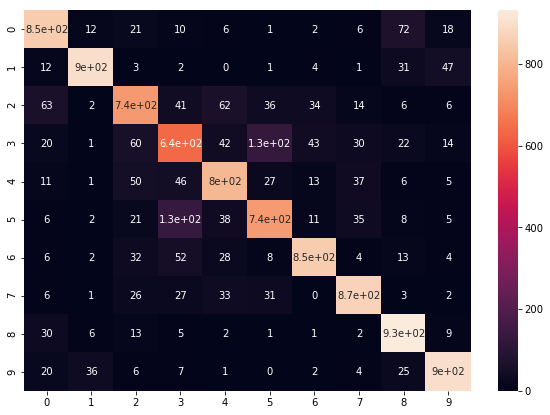

             precision    recall  f1-score   support

          0       0.83      0.85      0.84      1000
          1       0.93      0.90      0.92      1000
          2       0.76      0.74      0.75      1000
          3       0.66      0.64      0.65      1000
          4       0.79      0.80      0.80      1000
          5       0.76      0.74      0.75      1000
          6       0.89      0.85      0.87      1000
          7       0.87      0.87      0.87      1000
          8       0.83      0.93      0.88      1000
          9       0.89      0.90      0.89      1000

avg / total       0.82      0.82      0.82     10000

Accuracy: 0.8224


In [60]:
# get confusion matrix, classification report and accuracy score
from sklearn.metrics import classification_report, accuracy_score

print_cmx(y_test.T[0], y_testP)
print(classification_report(y_test.T[0], y_testP))
print("Accuracy: {0}".format(accuracy_score(y_test.T[0], y_testP)))

## Divide feature extraction layers and classification layers

In [61]:
# Layers definitions
from keras import backend as K
for l in range(len(model.layers)):
    print(l, model.layers[l])

0 <keras.layers.convolutional.Conv2D object at 0x7fbc0f92d780>
1 <keras.layers.core.Activation object at 0x7fbc0f92dc18>
2 <keras.layers.convolutional.Conv2D object at 0x7fbc0f92d0b8>
3 <keras.layers.core.Activation object at 0x7fbc0f92d710>
4 <keras.layers.pooling.MaxPooling2D object at 0x7fbc0f92d5c0>
5 <keras.layers.core.Dropout object at 0x7fbc0f92d400>
6 <keras.layers.convolutional.Conv2D object at 0x7fbc0f92d588>
7 <keras.layers.core.Activation object at 0x7fbc0f92d6d8>
8 <keras.layers.convolutional.Conv2D object at 0x7fbbdf94b470>
9 <keras.layers.core.Activation object at 0x7fbbdf94b860>
10 <keras.layers.pooling.MaxPooling2D object at 0x7fbbd9f046d8>
11 <keras.layers.core.Dropout object at 0x7fbbd9f04630>
12 <keras.layers.convolutional.Conv2D object at 0x7fbc0f92d4e0>
13 <keras.layers.core.Activation object at 0x7fbc0f86cd68>
14 <keras.layers.convolutional.Conv2D object at 0x7fbc0f86ce48>
15 <keras.layers.core.Activation object at 0x7fbb58cccf98>
16 <keras.layers.convolutional.C

In [62]:
# feature extraction layer
getFeature = K.function([model.layers[0].input, K.learning_phase()],
                        [model.layers[26].output])

In [63]:
# classification layer
getPrediction = K.function([model.layers[27].input, K.learning_phase()],
                           [model.layers[28].output])

## Get feature tensors for training and testing data

In [64]:
exTrain3000 = getFeature([x_train[:3000], 0])[0]

In [65]:
exTest1000 = getFeature([x_test[:1000], 0])[0]

In [66]:
# output of getFeature function
exTrain3000[0]

array([ 0.69946557,  0.18650442,  0.29139316, ...,  0.        ,
        0.        ,  0.31408471], dtype=float32)

## Reshape target to fit to scikit-learn

In [67]:
y_train3000 = y_train[:3000].reshape(y_train[:3000].shape[0],)
y_test1000 = y_test[:1000]

In [68]:
print(exTrain3000.shape, exTest1000.shape, y_train3000.shape, y_test1000.shape)

(3000, 1024) (1000, 1024) (3000,) (1000, 1)


## Grid search svm classification with feature extracted training data as input

In [78]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf'], 
              'C':[1, 10, 100, 1000],
              'gamma':[1e-3, 1e-4]}
clf = GridSearchCV(SVC(), parameters)
clf.fit(exTrain3000, y_train3000)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [79]:
svmclf = clf.best_estimator_
svmclf.fit(exTrain3000, y_train3000)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

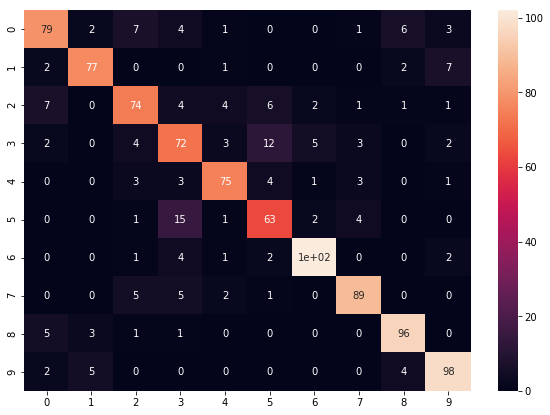

             precision    recall  f1-score   support

          0       0.81      0.77      0.79       103
          1       0.89      0.87      0.88        89
          2       0.77      0.74      0.76       100
          3       0.67      0.70      0.68       103
          4       0.85      0.83      0.84        90
          5       0.72      0.73      0.72        86
          6       0.91      0.91      0.91       112
          7       0.88      0.87      0.88       102
          8       0.88      0.91      0.89       106
          9       0.86      0.90      0.88       109

avg / total       0.83      0.82      0.83      1000

Accuracy: 0.825


In [80]:
y_testSVM = svmclf.predict(exTest1000)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print_cmx(y_test1000.T[0], y_testSVM)
print(classification_report(y_test1000, y_testSVM))
print("Accuracy: {0}".format(accuracy_score(y_test1000, y_testSVM)))

## Grid search random forest classification with feature extracted training data as input

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1.0, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": [10, 20, 50]}
rclf = RandomForestClassifier()
rgclf = GridSearchCV(rclf, param_grid=parameters)
rgclf.fit(exTrain3000, y_train3000)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, None], 'n_estimators': [10, 20, 50], 'min_samples_leaf': [1, 3, 10], 'min_samples_split': [1.0, 3, 10], 'bootstrap': [True, False], 'max_features': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [91]:
rclf = rgclf.best_estimator_
rclf.fit(exTrain3000, y_train3000)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

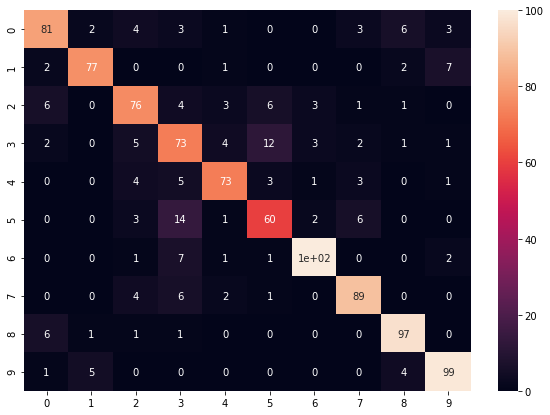

             precision    recall  f1-score   support

          0       0.83      0.79      0.81       103
          1       0.91      0.87      0.89        89
          2       0.78      0.76      0.77       100
          3       0.65      0.71      0.68       103
          4       0.85      0.81      0.83        90
          5       0.72      0.70      0.71        86
          6       0.92      0.89      0.90       112
          7       0.86      0.87      0.86       102
          8       0.87      0.92      0.89       106
          9       0.88      0.91      0.89       109

avg / total       0.83      0.82      0.83      1000

Accuracy: 0.825


In [92]:
y_testRF = rclf.predict(exTest1000)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print_cmx(y_test1000.T[0], y_testRF)
print(classification_report(y_test1000, y_testRF))
print("Accuracy: {0}".format(accuracy_score(y_test1000, y_testRF)))

## Grid search K nearest neighbors classification with feature extracted training data as input

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": [1, 5, 10, 30],
              "weights": ['uniform', 'distance'],
              "metric": ['minkowski','euclidean','manhattan'],
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
kclf = KNeighborsClassifier()
kgclf = GridSearchCV(kclf, param_grid=parameters)
kgclf.fit(exTrain3000, y_train3000)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'n_neighbors': [1, 5, 10, 30], 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [88]:
kclf = kgclf.best_estimator_
kclf.fit(exTrain3000, y_train3000)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance')

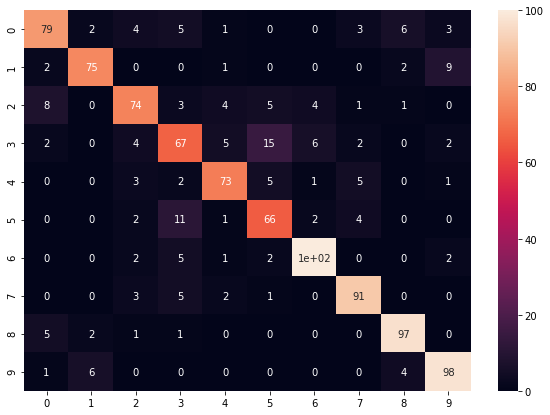

             precision    recall  f1-score   support

          0       0.81      0.77      0.79       103
          1       0.88      0.84      0.86        89
          2       0.80      0.74      0.77       100
          3       0.68      0.65      0.66       103
          4       0.83      0.81      0.82        90
          5       0.70      0.77      0.73        86
          6       0.88      0.89      0.89       112
          7       0.86      0.89      0.88       102
          8       0.88      0.92      0.90       106
          9       0.85      0.90      0.88       109

avg / total       0.82      0.82      0.82      1000

Accuracy: 0.82


In [89]:
y_testKNN = kclf.predict(exTest1000)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print_cmx(y_test1000.T[0], y_testKNN)
print(classification_report(y_test1000, y_testKNN))
print("Accuracy: {0}".format(accuracy_score(y_test1000, y_testKNN)))